In [1]:
import json

import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from naiveBayes import *
from sklearn.model_selection import train_test_split

In [7]:
# 读取数据
with open('tan/docs.txt', 'r', encoding='utf-8') as file:
    content = file.read()
    docs = eval(content)

with open('tan/label.txt', 'r', encoding='utf-8') as file:
    label = json.load(file)

with open('tan/pred.txt', 'r', encoding='utf-8') as file:
    content = file.read()
    content = content.strip('[]').strip()
    tan_pred = list(map(int, content.split()))

# 打开文件并读取
with open('tan/prob.txt', 'r', encoding='utf-8') as file:
    content = file.read()
    # 去掉开头和结尾的方括号，以及每行的开头和结尾的方括号
    content = content.strip()[1:-1].strip()
    # 分割每一行
    rows = content.split('\n')
    # 解析每一行
    tan_probs = [list(map(float, row.strip()[1:-1].split())) for row in rows]

In [8]:
vocabList = createVocabList(docs)
# 构建词向量矩阵
trainMat = []
for inputSet in tqdm(docs, desc='构建词向量矩阵'):
    trainMat.append(setOfWords2Vec(vocabList, inputSet))

X_train, X_test, y_train, y_test = train_test_split(trainMat, label, test_size=0.2, random_state=1)


构建词向量矩阵: 100%|██████████| 1000/1000 [00:00<00:00, 1771.86it/s]


In [12]:
# tan
tan_probs=tan_probs[:, 1]
fpr_tan, tpr_tan, _ = roc_curve(y_test, tan_probs)
roc_auc_tan = roc_auc_score(y_test, tan_probs)

In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from naiveBayes import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import naiveBayesv1 as v1

In [14]:
# SVM
svm = SVC(kernel='linear',probability=True)
svm.fit(X_train, y_train)

svm_pred = svm.predict(X_test)
svm_probs = svm.predict_proba(X_test)[:, 1] 

In [15]:
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)
roc_auc_svm = roc_auc_score(y_test, svm_probs)

In [16]:
# 朴素贝叶斯
nbmodel = MultinomialNB()
nbmodel.fit(X_train, y_train)

nb_pred = nbmodel.predict(X_test)
nb_probs = nbmodel.predict_proba(X_test)[:, 1] 

In [17]:
fpr_nb, tpr_nb, _ = roc_curve(y_test, nb_probs)
roc_auc_nb = roc_auc_score(y_test, nb_probs)

In [18]:
class LinearSVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in tqdm(range(self.n_iters), desc='训练SVM'):
            for idx, x_i in enumerate(X):
                condition = y[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y[idx]))
                    self.b -= self.lr * y[idx]

    def predict(self, X):
        return np.sign(np.dot(X, self.w) - self.b)

    def decision_function(self, X):
        return np.dot(X, self.w) - self.b

In [19]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

In [23]:
def tsvm_nb_algorithm(X, y):
    # 初始化距离矩阵
    n_samples = len(X)
    distance_matrix = np.full((n_samples, n_samples), np.inf)

    for i in tqdm(range(n_samples), desc='计算距离矩阵'):
        for j in range(n_samples):
            if i != j:
                distance_matrix[i, j] = euclidean_distance(X[i], X[j])

    # 初始化每个点的最近邻和最短距离
    nearest_neighbors = np.zeros(n_samples, dtype=int)
    min_distances = np.full(n_samples, np.inf)

    for i in tqdm(range(n_samples), desc='选择最近邻'):
        for j in range(n_samples):
            if distance_matrix[i, j] < min_distances[i]:
                min_distances[i] = distance_matrix[i, j]
                nearest_neighbors[i] = j

    # 初始化标志矩阵
    flags = np.ones(n_samples)

    for i in tqdm(range(n_samples), desc='计算标志矩阵'):
        neighbor_idx = nearest_neighbors[i]
        if y[i] != y[neighbor_idx]:
            flags[i] = -1
        else:
            flags[i] = 1

    # 收集需要删除的索引
    delete_indices = set()

    for i in tqdm(range(n_samples), desc='修剪样本集'):
        neighbor_idx = nearest_neighbors[i]
        if flags[i] == -1:
            # 选择删除点，优先删除距离较远的点
            if min_distances[i] < min_distances[neighbor_idx]:
                delete_indices.add(i)
            else:
                delete_indices.add(neighbor_idx)

    # 统一删除收集到的索引
    delete_indices = sorted(delete_indices, reverse=True)
    for idx in delete_indices:
        X = np.delete(X, idx, axis=0)
        y = np.delete(y, idx, axis=0)

    # 再次用NB算法训练
    nb = NaiveBayes()
    nb.fit(X, y)

    return nb

In [38]:
# 初始训练
nb_initial = NaiveBayes()
nb_initial.fit(X_train, y_train)
initial_predictions = nb_initial.predict(X_train)

# 构建最优分类超平面
svm = LinearSVM()
svm.fit(X_train, initial_predictions)

distances = svm.decision_function(X_train)
threshold = 0.2
selected_samples = np.abs(distances) > threshold

X_optimized = X_train[selected_samples]
y_optimized = y_train[selected_samples]

nb = tsvm_nb_algorithm(X_optimized, y_optimized)
y_pred = nb.predict(X_test)
y_probs = nb.predict_proba(X_test)[:, 1]  # 选择概率中的正类概率

修剪样本集: 100%|██████████| 800/800 [00:00<?, ?it/s]


In [36]:
fpr_TSVM, tpr_TSVM, _ = roc_curve(y_test, y_probs)
roc_auc_TSVM = roc_auc_score(y_test, y_probs)

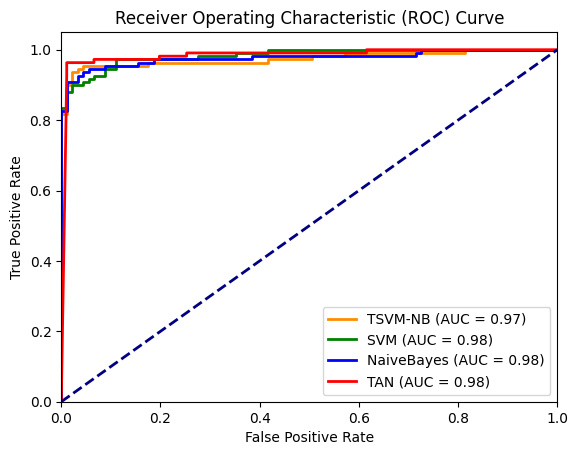

In [37]:
# 绘制ROC曲线
plt.figure()
plt.plot(fpr_TSVM, tpr_TSVM, color='darkorange', lw=2, label='TSVM-NB (AUC = %0.2f)' % roc_auc_TSVM)
plt.plot(fpr_svm, tpr_svm, color='green', lw=2, label='SVM (AUC = %0.2f)' % roc_auc_svm)
plt.plot(fpr_nb, tpr_nb, color='blue', lw=2, label='NaiveBayes (AUC = %0.2f)' % roc_auc_nb)
plt.plot(fpr_tan, tpr_tan, color='red', lw=2, label='TAN (AUC = %0.2f)' % roc_auc_tan)

# 绘制对角线
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# 设置图形的范围、标签和标题
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# 显示图形
plt.show()

In [33]:
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(y_test, y_pred)
mcc_svm=matthews_corrcoef(y_test,svm_pred)
mcc_nb=matthews_corrcoef(y_test,nb_pred)
mcc_tan=matthews_corrcoef(y_test,tan_pred)
print(mcc)
print(mcc_svm)
print(mcc_nb)
print(mcc_tan)

0.8845336935740052
0.8666053651488208
0.8845336935740052
0.929539499620758
